In [1]:
import polars as pl
from datetime import date

# 1. Data Reading

In [2]:
DATA_DIR = 'data'

load all 2024 months of taxi rides

`Note: Unfortunately, my old computer didn't allow me to run the notebook on full data, therefore i decided to reduce it only to months 1-9`

In [3]:
df = pl.scan_parquet("data/[1-9].parquet")

# df10 = pl.scan_parquet("data/10.parquet").with_columns(
#     pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
#     pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
# )
# df11 = pl.scan_parquet("data/11.parquet").with_columns(
#     pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
#     pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
# )
# df12 = pl.scan_parquet("data/12.parquet").with_columns(
#     pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
#     pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
# )
#
# df = pl.concat([df1to9, df10, df11, df12], how="vertical_relaxed")

out = df.collect()
print(out.height)
print(out.schema)


30021209
Schema({'VendorID': Int32, 'tpep_pickup_datetime': Datetime(time_unit='ns', time_zone=None), 'tpep_dropoff_datetime': Datetime(time_unit='ns', time_zone=None), 'passenger_count': Int64, 'trip_distance': Float64, 'RatecodeID': Int64, 'store_and_fwd_flag': String, 'PULocationID': Int32, 'DOLocationID': Int32, 'payment_type': Int64, 'fare_amount': Float64, 'extra': Float64, 'mta_tax': Float64, 'tip_amount': Float64, 'tolls_amount': Float64, 'improvement_surcharge': Float64, 'total_amount': Float64, 'congestion_surcharge': Float64, 'Airport_fee': Float64})


also load taxi zone lookup data

In [4]:
df_taxi_zones = pl.scan_csv("data/taxi_zone_lookup.csv")
print(df_taxi_zones.collect().height, df_taxi_zones.collect().schema, sep="\n")

265
Schema({'LocationID': Int64, 'Borough': String, 'Zone': String, 'service_zone': String})


include only rides starting in 2024 and ending at most at 01.01.2025

In [5]:
df = df.filter(
    (pl.col("tpep_pickup_datetime").dt.year() == 2024) &
    (pl.col("tpep_dropoff_datetime") < pl.datetime(2025, 1, 2))
)
df.collect().height

30021165

optimize data types, particularly for integers and categorical strings

In [6]:
df = df.cast({
    "passenger_count": pl.UInt8,
    "RatecodeID": pl.UInt8,
    "payment_type": pl.UInt8,
    "PULocationID": pl.UInt16,
    "DOLocationID": pl.UInt16,
    "store_and_fwd_flag": pl.Categorical
})

# 2. Data cleaning and filtering

- fill NULL values in passengers_count with 1
- remove rides with zero passengers
- if a ride has over 6 passengers, replace the value with 6
- remove rides lasting over 2 hours
- in all money-related columns, replace values with absolute value to fix negative amounts
- remove rides with over 1000 dollars in any money-related column
- remove rows with values of RatecodeID or VendorID missing or outside those defined in the data dictionary

In [7]:
money_related_cols = [
    "fare_amount",
    "extra",
    "tip_amount",
    "mta_tax",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
]

In [8]:
df = (df
    .with_columns(
        pl.col("passenger_count").fill_null(1)
    )
    .filter(
        pl.col("passenger_count") > 0
    )
    .with_columns(
        pl.col("passenger_count").clip(upper_bound=6)
    )
    .filter(
        (pl.col("tpep_pickup_datetime") - pl.col("tpep_dropoff_datetime")).dt.total_hours() < 2
    )
    .with_columns(
        pl.col(col).abs() for col in money_related_cols
    )
    .filter(
        pl.col(col) < 1000 for col in money_related_cols
    )
    .filter(
        pl.col("RatecodeID").is_in([1, 2, 3, 4, 5, 6, 99]),
        pl.col("VendorID").is_in([1, 2, 6, 7]),
    )
)

df.collect().schema

Schema([('VendorID', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('RatecodeID', UInt8),
        ('store_and_fwd_flag', Categorical(ordering='physical')),
        ('PULocationID', UInt16),
        ('DOLocationID', UInt16),
        ('payment_type', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('Airport_fee', Float64)])

# 3. Data transformation

- combine payment type values for "No charge", "Dispute", "Unknown" and "Voided trip" into one type, so we have only credit card, cash, or other
- replace PULocationID and DOLocationID with borough names by joining taxi zone lookup and removing unnecessary columns
- add boolean variable is_airport_ride, true if there is non-zero airport fee
- add boolean variable is_rush_hour, rush hours are defined as 6:30–9:30 and 15:30-20:00 during weekdays

In [9]:
df = (
    df
    .with_columns(
        pl.when(pl.col("payment_type").is_in([1, 2]))
        .then(pl.col("payment_type"))
        .otherwise(3)
    )
    .join(df_taxi_zones, left_on="PULocationID", right_on="LocationID")
    .rename({"Borough": "PUBorough",})
    .join(df_taxi_zones, left_on="DOLocationID", right_on="LocationID")
    .rename({"Borough": "DOBorough"})
    .drop("PULocationID", "DOLocationID", "Zone", "service_zone", "Zone_right", "service_zone_right")
    .with_columns(
        (pl.col("Airport_fee") > 0).alias("is_airport_ride")
    )
    .with_columns(
        (
            (
                (pl.col("tpep_pickup_datetime").dt.time().is_between(pl.time(6, 30), pl.time(9, 30))) |
                (pl.col("tpep_pickup_datetime").dt.time().is_between(pl.time(15, 30), pl.time(20, 0))) |
                (pl.col("tpep_dropoff_datetime").dt.time().is_between(pl.time(6, 30), pl.time(9, 30))) |
                (pl.col("tpep_dropoff_datetime").dt.time().is_between(pl.time(15, 30), pl.time(20, 0)))
            ) &
            (
                (pl.col("tpep_pickup_datetime").dt.weekday() < 6) &
                (pl.col("tpep_dropoff_datetime").dt.weekday() < 6)
            )
        )
        .alias("is_rush_hour")
    )
)

df.collect().schema

Schema([('VendorID', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('RatecodeID', UInt8),
        ('store_and_fwd_flag', Categorical(ordering='physical')),
        ('payment_type', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('Airport_fee', Float64),
        ('PUBorough', String),
        ('DOBorough', String),
        ('is_airport_ride', Boolean),
        ('is_rush_hour', Boolean)])

# 4. Feature extraction
   - apply dummy encoding to features:
     - payment type
     - pickup borough
     - dropoff borough
   - add integer variables for counting daily events:
     - total number of rides (target variable)
     - number of airport rides
     - number of rush hour rides
   - add features aggregating daily rides information:
     - average fare amount
     - median distance
     - sum of total amounts
     - total amount paid by card, cash, and other
     - total congestion surcharge
     - total number of passengers
   - add time features:
     - `quarter`
     - `month`
     - `day_of_month`
     - `day_of_week`
     - `is_weekend` (boolean)
   - add column `date`, indicating day with given features
   - make sure to exclude other columns, unnecessary for machine learning, e.g. IDs, timestamps, unused financial information
   - properly name all columns
   - save results as `dataset.parquet` file

In [10]:
df = (
    df
    .collect()
    .to_dummies(
        columns=['payment_type', 'PUBorough', 'DOBorough']
    )
    .lazy()
    .with_columns(
        pl.col("tpep_pickup_datetime").dt.date().alias('date'),
        pl.col('tpep_pickup_datetime').dt.ordinal_day().alias('ordinal_day'),
        pl.col('tpep_pickup_datetime').dt.quarter().alias('quarter'),
        pl.col('tpep_pickup_datetime').dt.month().alias('month'),
        pl.col('tpep_pickup_datetime').dt.day().alias('day_of_month'),
        pl.col('tpep_pickup_datetime').dt.weekday().alias('week_day'),
        (pl.col("tpep_pickup_datetime").dt.weekday() >= 6).alias('is_weekend'),
    )
    .group_by(
        "date",
        'ordinal_day',
        'quarter',
        'month',
        'day_of_month',
        'week_day',
        'is_weekend',
    )
    .agg(
        pl.len().alias('total_rides'),
        pl.col('is_airport_ride').sum().alias('num_airport_rides'),
        pl.col('is_rush_hour').sum().alias('num_rush_hour_rides'),

        pl.col('fare_amount').mean().alias('avg_fare_amount'),
        pl.col('trip_distance').median().alias('median_trip_distance'),
        pl.col('total_amount').sum().alias('total_amount'),
            pl.col('payment_type_1').sum().alias('total_paid_card'),
            pl.col('payment_type_2').sum().alias('total_paid_cash'),
            pl.col('payment_type_3').sum().alias('total_paid_other'),
        pl.col('congestion_surcharge').sum().alias('total_congestion_surcharge'),
        pl.col('passenger_count').sum().alias('total_passengers')
    )
    .sort('date')
)

df.collect()

date,ordinal_day,quarter,month,day_of_month,week_day,is_weekend,total_rides,num_airport_rides,num_rush_hour_rides,avg_fare_amount,median_trip_distance,total_amount,total_paid_card,total_paid_cash,total_paid_other,total_congestion_surcharge,total_passengers
date,i16,i8,i8,i8,i8,bool,u32,u32,u32,f64,f64,f64,i64,i64,i64,f64,i64
2024-01-01,1,1,1,1,1,false,69764,8365,20580,22.225501,2.09,2.1884e6,53038,14522,2204,156350.75,109331
2024-01-02,2,1,1,2,2,false,72667,9842,32802,21.533146,1.82,2.2550e6,55224,15421,2022,160772.5,104208
2024-01-03,3,1,1,3,3,false,79670,9174,35300,20.208847,1.75,2.3384e6,61415,16233,2022,178192.5,111168
2024-01-04,4,1,1,4,4,false,99177,8287,45798,18.8873,1.75,2.7652e6,78809,18023,2345,226800.0,136001
2024-01-05,5,1,1,5,5,false,98940,7471,42535,18.262269,1.7,2.6803e6,78762,17718,2460,227687.5,137309
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-09-27,271,3,9,27,5,false,109897,9759,45772,20.425495,1.7,3.2913e6,91170,15148,3579,251942.5,144922
2024-09-28,272,3,9,28,6,true,119678,7485,0,18.864051,1.64,3.2372e6,99576,16376,3726,280697.5,168790
2024-09-29,273,3,9,29,7,true,98441,11497,0,20.712102,1.8,2.9253e6,81649,13451,3341,224135.0,135908


In [11]:
df.collect().write_parquet("data/dataset.parquet")

# 5. Data analysis
   - print shape
   - show top rows
   - describe statistics
   - print schema
   - plot target variable (daily number of rides):
     - histogram of values
     - line plot, date vs number of rides (remember to sort by date)

In [12]:
df_collected = df.collect()

In [13]:
df_collected.shape

(275, 18)

In [14]:
df_collected.limit(5)

date,ordinal_day,quarter,month,day_of_month,week_day,is_weekend,total_rides,num_airport_rides,num_rush_hour_rides,avg_fare_amount,median_trip_distance,total_amount,total_paid_card,total_paid_cash,total_paid_other,total_congestion_surcharge,total_passengers
date,i16,i8,i8,i8,i8,bool,u32,u32,u32,f64,f64,f64,i64,i64,i64,f64,i64
2024-01-01,1,1,1,1,1,false,69764,8365,20580,22.225501,2.09,2.1884e6,53038,14522,2204,156350.75,109331
2024-01-02,2,1,1,2,2,false,72667,9842,32802,21.533146,1.82,2.2550e6,55224,15421,2022,160772.5,104208
2024-01-03,3,1,1,3,3,false,79670,9174,35300,20.208847,1.75,2.3384e6,61415,16233,2022,178192.5,111168
2024-01-04,4,1,1,4,4,false,99177,8287,45798,18.8873,1.75,2.7652e6,78809,18023,2345,226800.0,136001
2024-01-05,5,1,1,5,5,false,98940,7471,42535,18.262269,1.7,2.6803e6,78762,17718,2460,227687.5,137309


In [15]:
df_collected.describe()

statistic,date,ordinal_day,quarter,month,day_of_month,week_day,is_weekend,total_rides,num_airport_rides,num_rush_hour_rides,avg_fare_amount,median_trip_distance,total_amount,total_paid_card,total_paid_cash,total_paid_other,total_congestion_surcharge,total_passengers
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""275""",275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2024-05-17 00:00:00""",138.0,2.010909,5.025455,15.676364,3.981818,0.283636,97152.472727,8891.374545,30922.105455,19.898644,1.733018,2.8149e6,79641.705455,14797.701818,2713.065455,222972.416436,131123.290909
"""std""",null,79.529869,0.826052,2.5976,8.841714,2.008112,null,14512.529464,1613.589355,20324.286969,1.275212,0.108345,422103.887978,13012.614828,1631.747337,449.437259,35592.81169,17947.340091
"""min""","""2024-01-01""",1.0,1.0,1.0,1.0,1.0,0.0,15.0,2.0,0.0,16.69548,1.51,542.92,14.0,1.0,0.0,32.5,15.0
"""25%""","""2024-03-10""",70.0,1.0,3.0,8.0,2.0,null,87819.0,7963.0,0.0,19.042841,1.67,2.5637e6,71524.0,14049.0,2426.0,200520.0,121088.0
"""50%""","""2024-05-17""",138.0,2.0,5.0,16.0,4.0,null,98690.0,8898.0,40853.0,19.849665,1.7,2.8421e6,81339.0,14933.0,2759.0,227520.0,131958.0
"""75%""","""2024-07-25""",207.0,3.0,7.0,23.0,6.0,null,108324.0,10003.0,45806.0,20.651447,1.79,3.1027e6,89564.0,15778.0,3012.0,250097.5,144225.0
"""max""","""2024-10-01""",275.0,4.0,10.0,31.0,7.0,1.0,123754.0,12886.0,54186.0,24.533333,2.39,3.7472e6,103907.0,18023.0,3829.0,286325.0,169472.0


In [16]:
df_collected.schema

Schema([('date', Date),
        ('ordinal_day', Int16),
        ('quarter', Int8),
        ('month', Int8),
        ('day_of_month', Int8),
        ('week_day', Int8),
        ('is_weekend', Boolean),
        ('total_rides', UInt32),
        ('num_airport_rides', UInt32),
        ('num_rush_hour_rides', UInt32),
        ('avg_fare_amount', Float64),
        ('median_trip_distance', Float64),
        ('total_amount', Float64),
        ('total_paid_card', Int64),
        ('total_paid_cash', Int64),
        ('total_paid_other', Int64),
        ('total_congestion_surcharge', Float64),
        ('total_passengers', Int64)])

<Axes: title={'center': 'Daily Taxi Rides Histogram of 2024'}, xlabel='Total Rides', ylabel='Frequency'>

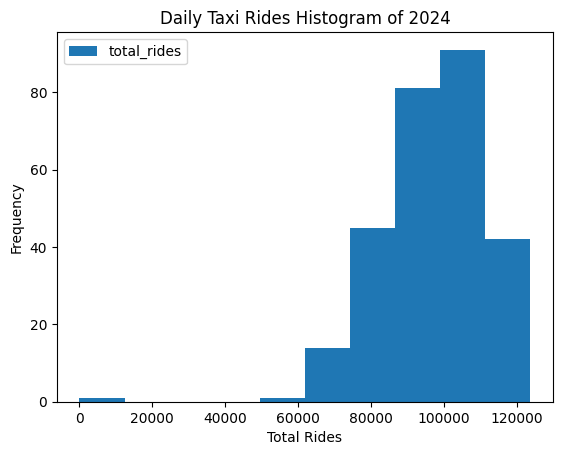

In [17]:
df_collected.select('total_rides').to_pandas().plot.hist(
    xlabel="Total Rides",
    title="Daily Taxi Rides Histogram of 2024",
)

<Axes: title={'center': 'Taxi Rides per Day in 2024'}, xlabel='Date', ylabel='Total Rides'>

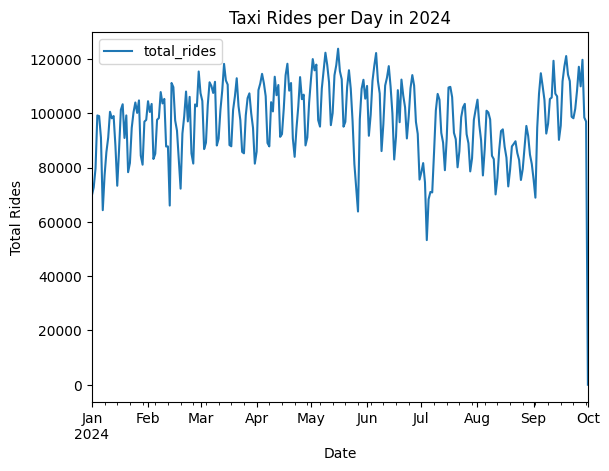

In [18]:
df_collected.select("date", "total_rides").sort("date").to_pandas().plot.line(
    x='date',
    y='total_rides',
    xlabel="Date",
    ylabel="Total Rides",
    title="Taxi Rides per Day in 2024",
)